In [3]:
% load model
load('Model_iJB785.mat');

model = iJB785; 
model


model = 

           mets: {768x1 cell}
       metNames: {768x1 cell}
    metFormulas: {768x1 cell}
          genes: {785x1 cell}
        grRules: {850x1 cell}
           rxns: {850x1 cell}
       rxnNames: {850x1 cell}
     subSystems: {850x1 cell}
         csense: 'EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE...'
              S: [768x850 double]
             lb: [850x1 double]
             ub: [850x1 double]
              b: [768x1 double]
              c: [850x1 double]
            rev: [850x1 int32]
    description: 'iJB785'



In [4]:
%% Suggested constraints for growth in continuous light
% Jared Broddrick 09/29/16
% 1) couple flux between transketolase and phophoketolase to make PDH
% essential
model.S(end+1,:) = 0;
model.b(end+1) = 0;
model.mets{end+1} = 'pkcc';
model.metNames{end+1} = 'Transketolase/Phosphoketolase coupling constraint';
model.csense(end+1) = 'G'; % such that 0.01*vTKT2 - vPKETF(or PKETX) >= 0
tkt2 = findRxnIDs(model,'TKT2');
pkf = findRxnIDs(model,'PKETF');
pkx = findRxnIDs(model,'PKETX');
model.S(end,pkf) = -1;
model.S(end,pkx) = -1;
model.S(end,tkt2) = -0.01;
model = addDemandReaction(model,'pkcc');
% 2) make VPAMTr irreversible towards alanine, forces use of GLUSfx
vpamt = findRxnIDs(model,'VPAMTr');
model.lb(vpamt)=-1000;
model.ub(vpamt)=0;
%3) transhydrogenase carries no flux
model = changeRxnBounds(model,'NADTRHD',0,'b');
%4) set transaldolase as irreversible towards e4p/f6p
model = changeRxnBounds(model,'TALA',0,'l');
%5) ornitine transaminase carries no flux; based on essentiality of proline and asparagine biosynthetic pathways
model = changeRxnBounds(model,'ORNTA',0,'b');
%6) CYOOum carries no flux
model = changeRxnBounds(model,'CYOOum',0,'b');
%7) LDH_D irrev way from pyruvate
model = changeRxnBounds(model,'LDH_D',0,'u');

DM_pkcc	pkcc 	->	


In [5]:
%% Set media to BG-11
% % Jared Broddrick 09/29/16

% BG-11 at 100mL total volume
% # media BG-11
% # BG-11
% # NaNO3:   17.6 mM     MgSO4:         0.3 mM
% # K2HPO4:  0.23 mM     citrate:       0.031 mM
% # CaCl2:   0.24 mM     FeNH4 citrate: 0.024 mM citrate, 0.031 mM ammonia,
%                                       0.010 mM Fe3 (based on 9% amm, 16%
%                                       Fe and 75% citrate
% # Na2EDTA: 0.0027 mM   Na2CO3:        0.19 mM
% # Trace solution: 1000x
% # H3BO3:   46 mM       MnCl2:         9mM
% # ZnSO4:   0.77 mM     Na2MoO4:       1.6mM
% # CuSO4:   0.3 mM      Co(NO3)2:      0.17 mM
% open up all exchange reaction so that products can be released
ex_r = strmatch('EX_',model.rxns);
for i = 1:length(ex_r)
    model.lb(ex_r(i)) = 0;
    model.ub(ex_r(i)) = 1000;
end
rxns = {'EX_h2o_e';'EX_o2_e';'EX_co2_e';'EX_cobalt2_e';'EX_zn2_e';'EX_so4_e';'EX_ca2_e';'EX_nh4_e';'EX_mn2_e';'EX_hco3_e';'EX_mg2_e';'EX_cu2_e';'EX_k_e';'EX_no3_e';'EX_fe3_e';'EX_mobd_e';'EX_na1_e';'EX_h_e';'EX_pi_e'};
bound = [-1000;-1000;-1000;-1.70000000000000e-05;-7.70000000000000e-05;-0.0300000000000000;-0.0240000000000000;-0.00310000000000000;-0.000900000000000000;-0.0190000000000000;-0.0300000000000000;-3.00000000000000e-05;-0.0460000000000000;-1.76000000000000;-0.00200000000000000;-0.000160000000000000;-1.79854000000000;-1000;-0.0230000000000000];
for i = 1:length(rxns)
    index = strmatch(rxns{i},model.rxns,'exact');
    model.lb(index)=bound(i);
end

In [6]:
%% Photon constraints
% This file assigns the optical absorption cross-section, the chlorophyll a
% composiiton of the biomass and the spectral irradiance.
% Jared Broddrick 09/29/16


% a is a*(bin) = optical absorption cross-section of the 20nm bin
% normalized to mg chl a; units: cm^2/mg ChlA

oabxc = [460.700000000000,598.900000000000,565.500000000000,415.200000000000,352.900000000000,277.700000000000,157.300000000000,124.300000000000,146.800000000000,193.200000000000,263.700000000000,335.800000000000,269,303.600000000000,267.700000000000];
% mean = [460.700000000000,598.900000000000,565.500000000000,415.200000000000,352.900000000000,277.700000000000,157.300000000000,124.300000000000,146.800000000000,193.200000000000,263.700000000000,335.800000000000,269,303.600000000000,267.700000000000]
% ub95 = [495.500000000000,645.300000000000,608.300000000000,446.400000000000,379.300000000000,298.600000000000,169.300000000000,133.800000000000,157.700000000000,207.900000000000,285.200000000000,364,291.200000000000,328,289.300000000000]
% lb95 = [425.900000000000,552.500000000000,522.600000000000,384,326.400000000000,256.800000000000,145.300000000000,114.900000000000,135.900000000000,178.500000000000,242.300000000000,307.600000000000,246.900000000000,279.100000000000,246]
disp('Optical absorption cross section')
disp('     nm         a*');
bins = [410;430;450;470;490;510;530;550;570;590;610;630;650;670;690];
disp([bins,oabxc']);
% Get chla composition of the biomass in mg Chla/1000 mg biomass
% Chla as a percent of pigments
r = strmatch('BM_PIGMENTS',model.rxns,'exact');
m1 = strmatch('cholphya_c',model.mets,'exact');
[~,~,chla_stoich] = find(model.S(m1,r));
chla = chla_stoich*893.4861/1000;% umol chla * umol/mg
% get pigments as a percent of biomass
r = strmatch('BOF',model.rxns,'exact');
m2 = strmatch('bm_pigm_c',model.mets,'exact');
[~,~,pigm] = find(model.S(m2,r));
a = oabxc.*(chla*pigm);

% Relative spectral distribution of Octron 741 4100K 32W light source
relArea = [0.0334,0.0931,0.0427,0.0400,0.0750,0.0238,0.0424,0.2089,0.0675,0.1089,0.1601,0.0595,0.0213,0.0141,0.0093];
conv = 60*60/10000; %converts photon flux from umol/(m2*s) to umol/(cm2*h)
irrad = [68]; %irradiance in uE
str_to_print = strcat('Irradiance: ',num2str(irrad));
disp(str_to_print);
pfd = relArea.*(conv);
% photon absorbtion rate = a*(bin) x photon flux density
pha = a.*pfd; %umol photons/(mgDW*h)
% xphr are exchange photon reactions
xphr = {'EX_photon410_e', 'EX_photon430_e', 'EX_photon450_e', 'EX_photon470_e', 'EX_photon490_e', 'EX_photon510_e', 'EX_photon530_e', 'EX_photon550_e', 'EX_photon570_e', 'EX_photon590_e', 'EX_photon610_e', 'EX_photon630_e', 'EX_photon650_e', 'EX_photon670_e', 'EX_photon690_e'};



Optical absorption cross section
     nm         a*
  410.0000  460.7000
  430.0000  598.9000
  450.0000  565.5000
  470.0000  415.2000
  490.0000  352.9000
  510.0000  277.7000
  530.0000  157.3000
  550.0000  124.3000
  570.0000  146.8000
  590.0000  193.2000
  610.0000  263.7000
  630.0000  335.8000
  650.0000  269.0000
  670.0000  303.6000
  690.0000  267.7000

Irradiance:68


In [7]:
%% Additional initializing values
% 2% of the culture volume in each ring
vol = [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2];
% initial mgDW of inoculation in a 100mL flask
iDW = 7.1; 
%area used for photon delivery
xsec = 54.3;
% relative volume
rv = vol./100;

In [8]:
%% Execute the simulation of no-shading
results = [];
%% Calculates the no shading growth rate
% Jared Broddrick 09/29/16

for z = 1:length(irrad)% If more than one irradiance is to be simulated
    % Reset media for new simulation at new irradiance
    ex_r = strmatch('EX_',model.rxns);
    for i = 1:length(ex_r)
        model.lb(ex_r(i)) = 0;
        model.ub(ex_r(i)) = 1000000;
    end
    rxns = {'EX_h2o_e';'EX_o2_e';'EX_co2_e';'EX_cobalt2_e';'EX_zn2_e';'EX_so4_e';'EX_ca2_e';'EX_nh4_e';'EX_mn2_e';'EX_hco3_e';'EX_mg2_e';'EX_cu2_e';'EX_k_e';'EX_no3_e';'EX_fe3_e';'EX_mobd_e';'EX_na1_e';'EX_h_e';'EX_pi_e'};
    bound = [-1000;-1000;-1000;-1.70000000000000e-05;-7.70000000000000e-05;-0.0300000000000000;-0.0240000000000000;-0.00310000000000000;-0.000900000000000000;-0.0190000000000000;-0.0300000000000000;-3.00000000000000e-05;-0.0460000000000000;-1.76000000000000;-0.00200000000000000;-0.000160000000000000;-1.79854000000000;-1000;-0.0230000000000000];
    bound = bound*1000;
    for i = 1:length(model.rxns)
        model.lb(i) = model.lb(i)*1000;
        model.ub(i) = model.ub(i)*1000;
    end
    for i = 1:length(rxns)
        index = strmatch(rxns{i},model.rxns,'exact');
        model.lb(index)=bound(i);
    end

    % set interval spacing in hours
    hours = linspace(0.1,240,2400);
    gDW = iDW; %Set the initial biomass at incoulation
    % initialize variables for output
    biomass = []; % biomass production over the simulation interval
    biomass = [biomass;iDW];

    for i = 1:length(hours)
        h = 0.1; %Time interval of simulation in hours
        sDW =gDW; %Since shading is not accounted for, the slice biomass DW is jus the total biomass DW at time i
        tpbm = 0; %initialize a variable to collect the biomass from each slice
        tppi = 0; %initialize a variable to collect the phosphate uptake from each slice
        spha = pha.*(sDW*irrad(z)*h); %sets photon absorption rate for the slice
        sphd = pfd.*(xsec*irrad(z)*h); %sets photon delivery rate for the slice
    
        %General constraints

        %Maintenance
        model = changeRxnBounds(model,'NGAM',(0.071*h*sDW),'l'); %non-growth associated maintenance
        %Carbon uptake
        cup = -2.0*sDW*h; %CO2 uptake, arbitrary, high value
        bicup = -2.0*sDW*h; % Bicarb uptake, arbitrary, high value
        model = changeRxnBounds(model,'EX_co2_e',cup,'l');
        model = changeRxnBounds(model,'EX_hco3_e',bicup,'l');
        %O2 evolution, P(I)=Ps(1-e^(-a*I/Ps))*e^(-BI/Ps) Platt fitting of
        %O2 evolution; Ps = 153, a = 1.42, B = 9.3E-14, I = irradiance
        o2rate =  153*(1-exp(-1.42*irrad(z)/153))*(exp(-9.3E-14*irrad(z)/153));
        o2evo = o2rate*sDW*h*(10/1000);
        model = changeRxnBounds(model,'EX_o2_e',o2evo,'u');
        % PSII max rate = 700umol O2/(mgChlA*hr)
        psii_max = 7*sDW*h;
        model = changeRxnBounds(model,'PSIIum',psii_max,'u');
        % Set photon exchange bounds
        for r = 1:length(xphr)

            if spha(r) < (sphd(r))
                model = changeRxnBounds(model,xphr{r},spha(r)*-0.9999,'u');
                model = changeRxnBounds(model,xphr{r},spha(r)*-1,'l');
            else
                model = changeRxnBounds(model,xphr{r},sphd(r)*-0.9999,'u');
                model = changeRxnBounds(model,xphr{r},sphd(r)*-1,'l');
            end

        end
        model = changeObjective(model,'BOF'); %Set objective to max growth
        solution = optimizeCbModel(model);
        % collect biomass, update attenuated light and pi usage
        if solution.stat == 1
            tpbm = tpbm+solution.f;
            % account for phosphate fixed into biomass
            phos = strmatch('EX_pi_e',model.rxns);
            vals = solution.x(phos);
            tppi = tppi+vals;
        else
            tpbm = tpbm+0;
            % account for phosphate fixed into biomass
            tppi = tppi+0;
        end
        % update gDW with the sum of the biomass from all slices
        gDW = gDW+tpbm;
        biomass = [biomass;gDW];
        %update phosphate bounds 
        new_bound = model.lb(phos)-tppi;
        if new_bound > 0
            new_bound = 0;
        end
        model = changeRxnBounds(model,'EX_pi_e',new_bound,'l');
        [i,gDW,new_bound];
    end
    results = [results,biomass];
end


Error using solveCobraLP (line 107)
No solver found.  call changeCobraSolver(solverName)

Error in optimizeCbModel (line 219)
    solution = solveCobraLP(LPproblem);



Error: -1

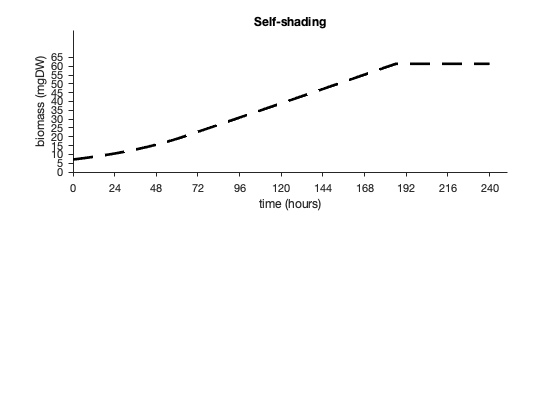

In [9]:
%% Plot shading and non-shading growth curves
% Jared Broddrick 09/29/16

figure('position',[50 50 400 600])
% Plot self-shading
subplot(2,1,1)
hold on
plot(0:240,self, 'k--' ,'LineWidth' ,2)
title('Self-shading','FontSize',12,'FontWeight','bold')
xlabel('time (hours)')
ylabel('biomass (mgDW)')
% Format
set(gca,'YTick',0:5:max(max(self)*1.1));
set(gca,'XTick',0:24:((length(self))));
set(gca,'FontSize',8)
set(gca,'Box','off');
set(gca,'TickDir','out');


In [ ]:

% Plot no shading
subplot(2,1,2)
hold on
no_shade_x = linspace(0.1,240,2400);
no_shade_x = [0,no_shade_x];
plot(no_shade_x,results','b-','LineWidth',3)
title('No shading','FontSize',12,'FontWeight','bold')
xlabel('time (hours)')
ylabel('biomass (mgDW)')
% Format
set(gca,'YTick',0:5:max(max(results)*1.1));
set(gca,'XTick',0:24:((length(results)/10)));
set(gca,'FontSize',8)
set(gca,'Box','off');
set(gca,'TickDir','out');


